In [2]:
import string
import types
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from collections import defaultdict

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords

from hlda import nCRPTree, Node
from wordcloud import WordCloud

In [3]:
newsgroups_data = fetch_20newsgroups(
    subset='train', 
    remove=('headers','footers','quotes')
)

raw_docs = newsgroups_data.data
labels = newsgroups_data.target
target_names = newsgroups_data.target_names

print(f"Number of documents: {len(raw_docs)}")
print(f"Number of categories: {len(target_names)}")
print("Sample categories:", target_names[:5])

Number of documents: 11314
Number of categories: 20
Sample categories: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']


In [5]:
def preprocess_text(text, 
                   stop_words=set(stopwords.words('english')),
                   stemmer=PorterStemmer(),
                   lemmatizer=WordNetLemmatizer(),
                   min_word_length=2):
    """
    Preprocesses the input text by:
    1. Lowercasing
    2. Tokenizing
    3. Removing non-alphabetic tokens and stopwords
    4. Applying stemming and lemmatization
    5. Filtering out very short tokens
    """
    # 1. Lowercase
    text = text.lower()
    
    # 2. Tokenize
    tokens = word_tokenize(text)
    
    # 3. Remove non-alphabetic tokens and stopwords
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words and len(t) >= min_word_length]
    
    # 4. Apply Stemming and Lemmatization
    stemmed = [stemmer.stem(t) for t in tokens]
    lemmatized = [lemmatizer.lemmatize(t) for t in stemmed]
    
    return lemmatized

In [6]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

preprocessed_docs = []
for doc in raw_docs:
    cleaned_tokens = preprocess_text(doc, stop_words=stop_words)
    preprocessed_docs.append(cleaned_tokens)

doc_lengths = [len(doc) for doc in preprocessed_docs]
print(f"Before filtering short docs:")
print(f"  Avg length: {np.mean(doc_lengths):.2f} tokens")
print(f"  Median length: {np.median(doc_lengths)}")
print(f"  Min length: {np.min(doc_lengths)}")
print(f"  Max length: {np.max(doc_lengths)}")

Before filtering short docs:
  Avg length: 91.24 tokens
  Median length: 40.0
  Min length: 0
  Max length: 6217


In [7]:
MIN_LENGTH = 25

filtered_docs = []
filtered_labels = []

for doc, label in zip(preprocessed_docs, labels):
    if len(doc) >= MIN_LENGTH:
        filtered_docs.append(doc)
        filtered_labels.append(label)

print(f"Documents after filtering short ones: {len(filtered_docs)}")

# Re-check stats
doc_lengths_filtered = [len(doc) for doc in filtered_docs]
print(f"After filtering docs under {MIN_LENGTH} tokens:")
print(f"  Avg length: {np.mean(doc_lengths_filtered):.2f} tokens")
print(f"  Median length: {np.median(doc_lengths_filtered)}")
print(f"  Min length: {np.min(doc_lengths_filtered)}")
print(f"  Max length: {np.max(doc_lengths_filtered)}")

Documents after filtering short ones: 7646
After filtering docs under 25 tokens:
  Avg length: 128.84 tokens
  Median length: 62.0
  Min length: 25
  Max length: 6217


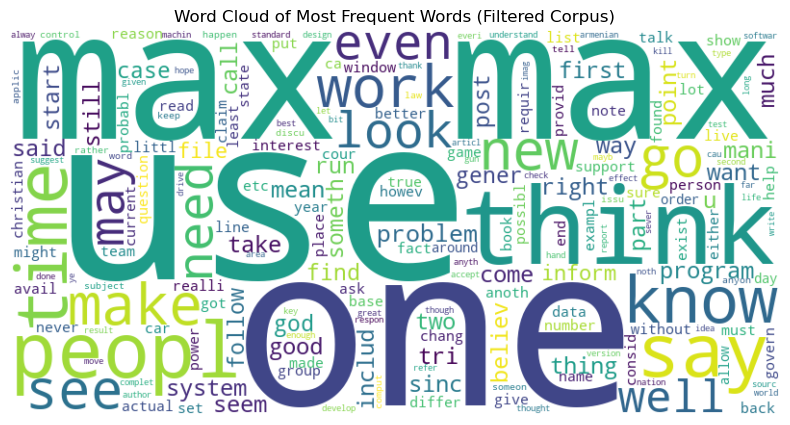

In [8]:
all_tokens = [token for doc in filtered_docs for token in doc]
text_for_cloud = " ".join(all_tokens)

wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white',
    max_words=200
).generate(text_for_cloud)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Most Frequent Words (Filtered Corpus)")
plt.show()

In [38]:
gamma = 1.0
eta = 0.1
max_level = 5
m = 0.5
pi = 1.0
num_iterations = 100

temp = filtered_docs[:500]

In [43]:
tree = nCRPTree(
    corpus=temp, 
    gamma=gamma, 
    eta=eta, 
    max_level=max_level, 
    vocab=list(set([token for doc in temp for token in doc])),  # Unique tokens
    m=m, 
    pi=pi
)


In [44]:
print(f"Initialized nCRPTree with {len(temp)} documents and vocabulary size {len(tree.vocab)}.")

Initialized nCRPTree with 500 documents and vocabulary size 10050.


In [45]:
def gibbs_sampling(self, num_iterations, verbose=True, print_every=10):
    for it in range(1, num_iterations + 1):
        for doc_id in list(self.paths.keys()):
            dw = self.document_words[doc_id]
            dl = self.levels[doc_id]
            self.sample_path(doc_id, dw, dl)
            self.sample_levels_for_document(doc_id)
        
        if verbose and it % print_every == 0:
            print(f"Completed iteration {it}/{num_iterations}")
    
    print("Gibbs sampling completed.")
    print(f"Total nodes created ever: {Node.last_node_id}")
    print(f"Active nodes in the tree now: {Node.total_nodes}")

# Assign the modified method to the tree instance
import types
tree.gibbs_sampling = types.MethodType(gibbs_sampling, tree)

# Run Gibbs Sampling
print(f"Starting Gibbs sampling for {num_iterations} iterations...")
tree.gibbs_sampling(num_iterations=num_iterations, verbose=True, print_every=10)

Starting Gibbs sampling for 100 iterations...
Completed iteration 10/100
Completed iteration 20/100
Completed iteration 30/100
Completed iteration 40/100
Completed iteration 50/100
Completed iteration 60/100
Completed iteration 70/100
Completed iteration 80/100
Completed iteration 90/100
Completed iteration 100/100
Gibbs sampling completed.
Total nodes created ever: 2386903
Active nodes in the tree now: 3377


In [46]:
def get_top_words_per_topic(tree, top_n=10):
    """
    Extracts top N words for each topic at each level.
    
    Args:
        tree (nCRPTree): The trained hierarchical LDA model.
        top_n (int): Number of top words to extract per topic.
    
    Returns:
        top_words (dict): {level: {node_id: [top words]}}
    """
    top_words = defaultdict(dict)
    
    for doc_id, path_nodes in tree.paths.items():
        for lvl, node in enumerate(path_nodes):
            if lvl >= tree.max_level:
                continue
            # Get top_n words for this node
            sorted_words = sorted(node.word_counts.items(), key=lambda x: x[1], reverse=True)
            top_n_words = [word for word, count in sorted_words[:top_n]]
            # Avoid duplicates
            if top_n_words not in top_words[lvl].values():
                top_words[lvl][node.node_id] = top_n_words
    
    return top_words

# Extract top words
top_words = get_top_words_per_topic(tree, top_n=10)

# Display top words per topic at each level
for lvl in sorted(top_words.keys()):
    print(f"\nTop words at Level {lvl}:")
    for node_id, words in top_words[lvl].items():
        print(f"  Topic {node_id}: {', '.join(words)}")


Top words at Level 0:
  Topic 2157186: 

Top words at Level 1:
  Topic 2157267: 

Top words at Level 2:
  Topic 2157389: 

Top words at Level 3:
  Topic 2335901: 

Top words at Level 4:
  Topic 2384632: car, anyon, look, wonder, could, enlighten, saw, day, sport, late
  Topic 2380601: info, thank, speed, upgrad, clock, experi, poll, plea, add, day
  Topic 2381018: would, display, could, well, machin, look, powerbook, anybodi, heard, system
  Topic 2384645: bug, warn, see, would, one, say, biker, face, sunglass, understand
  Topic 2384650: weapon, use, allow, conceal, one, would, question, firearm, law, carri
  Topic 2379287: leagu, thank, thought, make, stat, player, expans, talent, could, peopl
  Topic 2384659: scsi, chip, burst, control, mac, use, fast, quadra, mode, ibm
  Topic 2381076: board, problem, stac, file, technolog, sinc, licens, lost, icon, decompress
  Topic 2384669: leak, oil, bike, irwin, line, ducati, model, clock, run, well
  Topic 2384674: may, moral, parent, child,

# 2. Second implementation

In [9]:
from hlda_final import *

In [13]:
# Limit to the first 500 documents
NUM_DOCUMENTS = 500

filtered_docs = filtered_docs[:NUM_DOCUMENTS]
filtered_labels = filtered_labels[:NUM_DOCUMENTS]

print(f"Using the first {NUM_DOCUMENTS} documents for analysis.")
print(f"Number of documents after selection: {len(filtered_docs)}")

Using the first 500 documents for analysis.
Number of documents after selection: 500


In [14]:
from collections import defaultdict

def build_vocabulary(docs, min_freq=5):
    """
    Builds a vocabulary dictionary mapping words to unique indices.
    Words with frequency less than min_freq are excluded.
    """
    word_freq = defaultdict(int)
    for doc in docs:
        for word in doc:
            word_freq[word] += 1
    
    # Filter out rare words
    vocab = sorted([word for word, freq in word_freq.items() if freq >= min_freq])
    
    # Create word to index mapping
    word2idx = {word: idx for idx, word in enumerate(vocab)}
    idx2word = {idx: word for word, idx in word2idx.items()}
    
    return vocab, word2idx, idx2word

# Parameters
MIN_WORD_FREQ = 5  # You can adjust this based on the subset's vocabulary size

# Build vocabulary
vocabulary, word2idx, idx2word = build_vocabulary(filtered_docs, min_freq=MIN_WORD_FREQ)

print(f"Vocabulary size (words with freq >= {MIN_WORD_FREQ}): {len(vocabulary)}")

Vocabulary size (words with freq >= 5): 2469


In [15]:
def convert_docs_to_indices(docs, word2idx):
    """
    Converts a list of documents (list of words) to a corpus of word indices.
    Words not in the vocabulary are ignored.
    """
    corpus = []
    for doc in docs:
        indexed_doc = [word2idx[word] for word in doc if word in word2idx]
        corpus.append(indexed_doc)
    return corpus

# Convert filtered documents to corpus of word indices
corpus = convert_docs_to_indices(filtered_docs, word2idx)

print(f"Number of documents in corpus: {len(corpus)}")
print(f"Sample document (word indices): {corpus[0][:20]}")  # Print first 20 word indices of the first document

Number of documents in corpus: 500
Sample document (word indices): [2431, 92, 496, 321, 1913, 551, 2082, 321, 1286, 1222, 671, 310, 650, 1785, 2026, 27, 885, 1960, 1845, 257]


In [16]:
# Parameters for HLDA
ALPHA = 10.0    # Smoothing parameter for document-topic distributions
GAMMA = 1.0     # CRP parameter
ETA = 0.1       # Smoothing parameter for topic-word distributions
SEED = 42       # Random seed for reproducibility
VERBOSE = True
NUM_LEVELS = 3  # Depth of the hierarchy

# Initialize HLDA model
hlda_model = HierarchicalLDA(
    docs=corpus,
    vocabulary=vocabulary,
    alpha=ALPHA,
    gamma=GAMMA,
    eta=ETA,
    seed=SEED,
    verbose=VERBOSE,
    levels=NUM_LEVELS
)

print("HLDA model initialized.")

HLDA model initialized.


In [17]:
# Sampling parameters
NUM_ITERATIONS = 100          # Total number of sampling iterations
DISPLAY_INTERVAL = 100         # Interval at which to display progress
TOP_N_WORDS = 10               # Number of top words to display per topic
SHOW_WORD_COUNTS = True        # Whether to display word counts alongside words

# Fit the HLDA model
hlda_model.run_sampler(
    iterations=NUM_ITERATIONS,
    topic_display_interval=DISPLAY_INTERVAL,
    top_n_words=TOP_N_WORDS,
    show_word_counts=SHOW_WORD_COUNTS
)

print("HLDA model fitting completed.")

Starting Hierarchical LDA sampling

.................................................................................................... 100
topic=0 level=0 (docs=500): would (314), one (268), get (201), know (190), time (169), think (167), like (165), peopl (148), could (138), say (136)
    topic=1 level=1 (docs=213): use (86), also (62), plea (52), file (39), imag (39), get (37), one (33), would (33), like (32), much (31)
        topic=2 level=2 (docs=59): window (31), memori (27), use (27), program (25), problem (25), run (24), card (22), machin (22), simm (20), need (18)
        topic=5 level=2 (docs=6): church (24), human (18), natur (17), believ (16), divin (16), coptic (13), monophysit (12), nestoriu (10), jesu (10), council (9)
        topic=8 level=2 (docs=4): bill (29), gun (25), state (20), order (13), fid (13), law (12), restrain (11), testifi (11), hear (10), got (9)
        topic=9 level=2 (docs=14): water (20), do (12), call (12), system (9), board (8), caus (8), day (7)